# Introduction

There is a way to improve the performance of a model even after traning it, which is called Curve Calibration.

The issue is that a trained classifier is uncalibrated, meaning what it is overconfident or underconfident in some regions. 

The calibration of probabilities allows us to transform the predicted probabilities of a model into a probability distribution that matches the empirical distribution of the target variable.

In other words we chain a new model to the trained model that predicts calibrated probabilities.



# Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Read Data

In [6]:
df = pd.read_csv('heart.csv')

In [7]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [8]:
df = df.sample(frac=1).reset_index(drop=True)
df = df[['target',
 'exang',
 'cp',
 'oldpeak',
 'thalach',
 'ca',
 'slope',
 'thal',
 'sex',
 'age',
 'trestbps',
 'restecg']]

In [9]:
train_frac = 0.33
test_frac = 0.33

train_X = df[[c for c in df.columns if c != 'target']].iloc[:int(len(df) * train_frac)].values
train_y = df.target.iloc[:int(len(df) * train_frac)].values

test_X = df[[c for c in df.columns if c != 'target']].iloc[int(len(df) * train_frac):int(len(df) * (train_frac+test_frac))].values
test_y = df.target.iloc[int(len(df) * train_frac):int(len(df) * (train_frac+test_frac))].values

valid_X = df[[c for c in df.columns if c != 'target']].iloc[int(len(df) * (train_frac+test_frac)):].values
valid_y = df.target.iloc[int(len(df) * (train_frac+test_frac)):].values

# Train Models and get Probabilities (Uncalibrated for now)

In [13]:
model_to_clf = {
    'rf': RandomForestClassifier,
    'svc': SVC,
    'nb': GaussianNB
               }

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.svm._classes.SVC'>
<class 'sklearn.naive_bayes.GaussianNB'>


/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

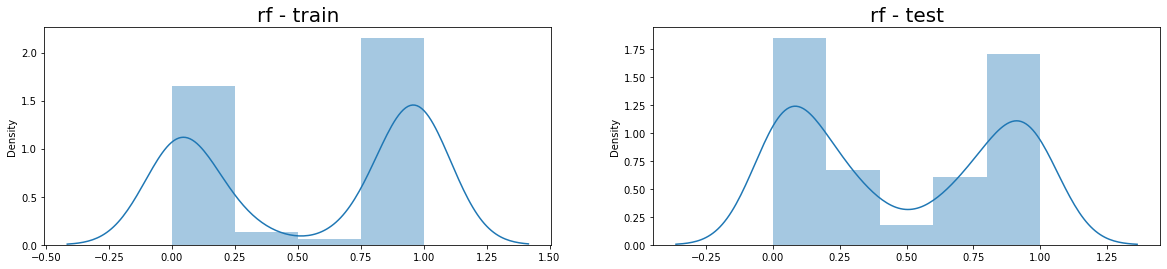

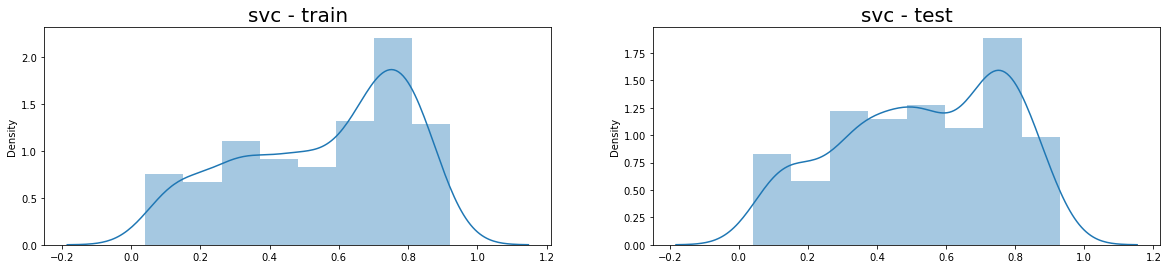

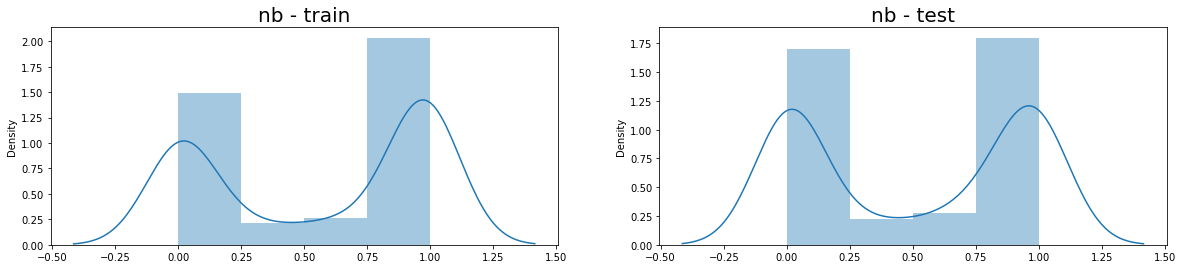

In [14]:
model_to_probs = {}
model_str_to_trained_model = {}

for model_str, model in model_to_clf.items():
    print(model)
    if model == SVC:
        clf = model(probability=True)
    elif model == LogisticRegression:
        clf = model(solver='liblinear')
    else:
        clf = model()
        
    clf.fit(train_X, train_y)
    
    pred_probs_train = clf.predict_proba(train_X)[:,1]
    pred_probs_test = clf.predict_proba(test_X)[:,1]
    pred_probs_valid = clf.predict_proba(valid_X)[:,1]
    
    model_to_probs[model_str] = {'train': pred_probs_train, 'test': pred_probs_test, 'valid': pred_probs_valid}
    
    plt.figure(figsize=(20,4))
    
    plt.subplot(1,2,1)
    sns.distplot(pred_probs_train)
    plt.title(f"{model_str} - train", fontsize=20)
    
    plt.subplot(1,2,2)
    sns.distplot(pred_probs_test)
    plt.title(f"{model_str} - test", fontsize=20)
    
    model_str_to_trained_model[model_str] = clf

# Plot Predicted Probabilities vs Empirical Probabilities

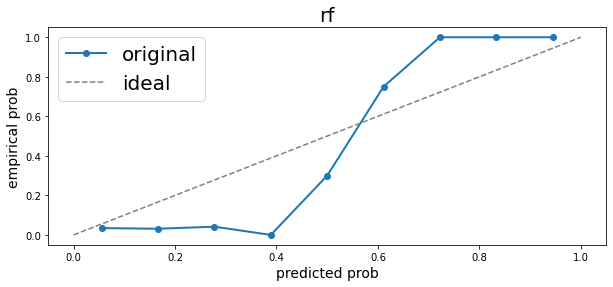

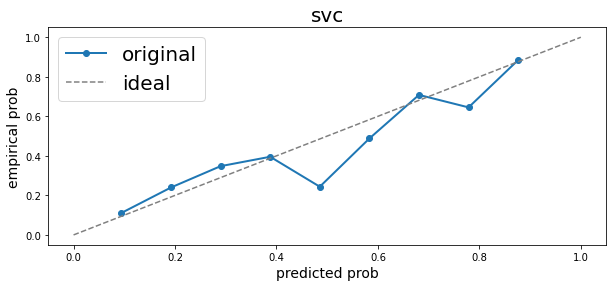

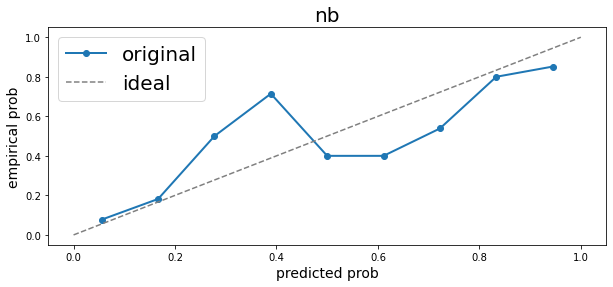

In [12]:
for model_str, pred_prob_dict in model_to_probs.items():
    pred_probs = pred_prob_dict['test']

    pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

    empirical_probs = []
    pred_probs_midpoints = []

    for i in range(len(pred_probs_space)-1):
        empirical_probs.append(np.mean(test_y[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
        pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

    plt.figure(figsize=(10,4))
    plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
    plt.title(f"{model_str}", fontsize=20)
    plt.xlabel('predicted prob', fontsize=14)
    plt.ylabel('empirical prob', fontsize=14)
    
    plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
    plt.legend(['original', 'ideal'], fontsize=20)

# Calibration of the probabilities

C:\Users\ritvik\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ritvik\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


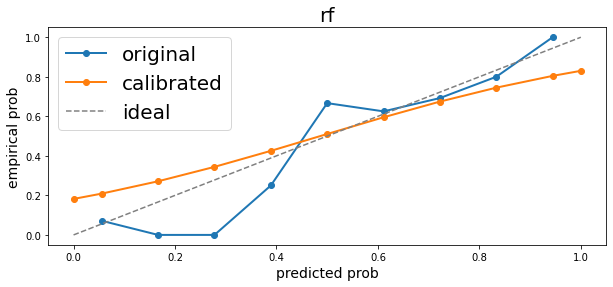

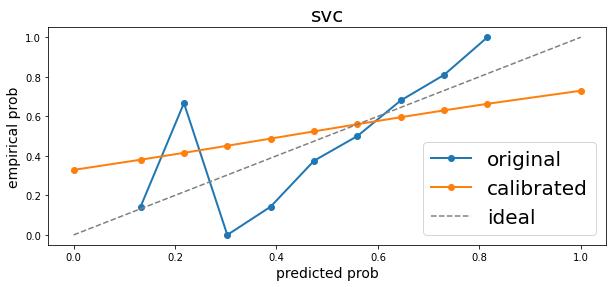

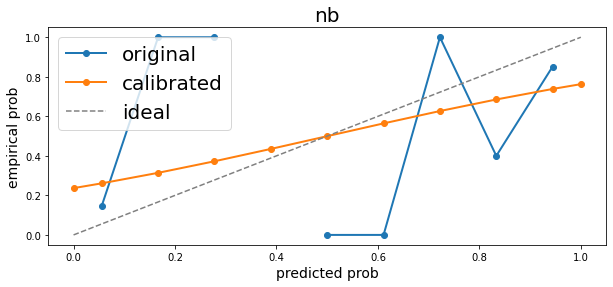

In [8]:
model_str_to_calibrator = {}

for model_str, pred_prob_dict in model_to_probs.items():
    #train calibration model
    lr_model = LogisticRegression()
    lr_model.fit(pred_prob_dict['test'].reshape(-1,1), test_y)
    
    pred_probs = pred_prob_dict['valid']

    pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

    empirical_probs = []
    pred_probs_midpoints = []

    for i in range(len(pred_probs_space)-1):
        empirical_probs.append(np.mean(valid_y[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
        pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

    calibrated_probs = lr_model.predict_proba(np.array([0.0]+pred_probs_midpoints+[1.0]).reshape(-1,1))[:,1]
    
    plt.figure(figsize=(10,4))
    plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
    plt.title(f"{model_str}", fontsize=20)
    plt.xlabel('predicted prob', fontsize=14)
    plt.ylabel('empirical prob', fontsize=14)
    
    plt.plot([0.0]+pred_probs_midpoints+[1.0], calibrated_probs, linewidth=2, marker='o')
    
    plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
    plt.legend(['original', 'calibrated', 'ideal'], fontsize=20)
    
    model_str_to_calibrator[model_str] = lr_model